In [1]:
import pandas as pd
import re
import numpy as np
# Set pandas option to display all rows
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

In [2]:
df = pd.read_csv('.\\data\\train.csv')
#df = pd.read_csv('.\\data\\test.csv')

## Data cleaning for column: fuel_type

In [3]:
def replace_fuel(row):
    if row['fuel_type'] == 'not supported':
        match = re.search(r'(\b\w+ Fuel\b)', row['engine'])
        if match:
            fuel_type = match.group(1).split()[0]
            return fuel_type
    elif row['fuel_type'] == '–':
        return np.nan
    return row['fuel_type']

# Apply the function to the 'Fuel' column
df['fuel_type'] = df.apply(replace_fuel, axis=1)

In [4]:
len(df) - df['engine'].str.contains('HP').sum()

4057

## Data cleaning for column: engine

In [5]:
# Replace 'engine gasoline fuel' with an empty string
df['engine'] = df['engine'].str.replace('Engine Gasoline Fuel', '', regex=False, case=False).str.strip()
df['engine'] = df['engine'].str.replace('Engine Flex Fuel Capability', '', regex=False, case=False).str.strip() 
df['engine'] = df['engine'].str.replace('Engine Diesel Fuel', '', regex=False, case=False).str.strip() 
# Replace ' Liter' with 'L' and join with the previous string
df['engine'] = df['engine'].str.replace(r'(\d\.\d) Liter', r'\1L', regex=True)

In [6]:
# Extract engine_power
df['engine_power'] = df['engine'].str.extract(r'(\d+\.\d+HP|\d+HP)', expand=False)

# Extract engine_volume
df['engine_volume'] = df['engine'].str.extract(r'(\d+\.\d+L|\d+L)', expand=False)

# Handle special case for entries like "6.7 L/406"
special_pattern = re.compile(r'(\d+\.\d+\s*L/\d+)')
special_volumes = df['engine'].str.extract(special_pattern, expand=False)
df['engine_volume'] = df['engine_volume'].fillna(special_volumes.str.extract(r'(\d+\.\d+\s*L)', expand=False))

# Remove extracted parts from engine column
df['engine'] = df['engine'].str.replace(r'(\d+\.\d+HP|\d+HP)', '', regex=True)
df['engine'] = df['engine'].str.replace(r'(\d+\.\d+L|\d+L)', '', regex=True)
df['engine'] = df['engine'].str.replace(special_pattern, '', regex=True)

# Clean up extra spaces
df['engine'] = df['engine'].str.strip()

# Clean up extra spaces
df['engine'] = df['engine'].str.strip()

In [7]:
# Replace '-' and empty strings with np.nan
df['engine'] = df['engine'].replace(['–'], np.nan).str.strip()
#'–', ''

In [8]:
# Define a function to extract the cylinder part and update the engine column
def extract_engine_cylinder(engine_str):
    if pd.isna(engine_str):
        return np.nan, engine_str
    
    # Regular expression to find strings that start with a letter followed by a number
    match = re.match(r'^([A-Za-z]\d+)', engine_str)
    if match:
        engine_cylinder = match.group(1)
        new_engine_str = engine_str[len(engine_cylinder):].strip()
        return engine_cylinder, new_engine_str
    else:
        return np.nan, engine_str

# Apply the function to the 'engine' column using .loc to avoid the warning
df['engine_cylinder'], df['engine'] = zip(*df['engine'].apply(extract_engine_cylinder))

In [9]:
'''
The function attempts to extract the number of cylinders from the 'engine' column value  and populate the missing values in 'engine_cylinder' if possible. 
It also updates the 'engine' column value to remove the extracted cylinder count.
 '''
def update_engine_cylinder(row):
    if pd.isna(row['engine_cylinder']):
        engine_str = str(row['engine'])  # Convert to string to avoid errors
        match = re.search(r'(\d+)\s+Cylinder', engine_str)
        if match:
            row['engine_cylinder'] = int(match.group(1))
            row['engine'] = re.sub(r'\d+\s+Cylinder', 'Cylinder', engine_str)
    return row

# Apply the function to each row
df = df.apply(update_engine_cylinder, axis=1)

In [10]:
def clean_string(s):
    if isinstance(s, str):  # Check if s is a string
        s = s.replace('PDI', 'GDI')  # Replace 'PDI' with 'GDI'
        s = re.sub(r'\d+V ', '', s)  # Remove digits followed by 'V' and the trailing space
    return s

# Apply the function to the DataFrame column
df['engine'] = df['engine'].apply(clean_string)

In [11]:
# Function to update the 'engine' and 'cylinder_shape' columns
def update_engine_cylinder(row):
    # Initialize cylinder_shape
    row['cylinder_shape'] = ''

    # Handle the engine_cylinder column
    if pd.notna(row['engine_cylinder']):
        # Extract letters and digits
        match = re.match(r'([A-Za-z]*)(\d+)', str(row['engine_cylinder']))
        if match:
            letters = match.group(1)
            digits = match.group(2)
            
            # Update the 'cylinder_shape' column with the letters
            row['cylinder_shape'] = letters
            
            # Update the 'engine_cylinder' column with the digits
            row['engine_cylinder'] = digits

    # Handle the engine column for 'straight' and 'flat'
    if pd.notna(row['engine']):
        engine_lower = row['engine'].lower()
        if 'straight' in engine_lower:
            row['cylinder_shape'] = 'Straight'
            row['engine'] = re.sub(r'straight', '', row['engine'], flags=re.IGNORECASE).strip()
        elif 'flat' in engine_lower:
            row['cylinder_shape'] = 'Flat'
            row['engine'] = re.sub(r'flat', '', row['engine'], flags=re.IGNORECASE).strip()

    return row

# Apply the function to each row
df = df.apply(update_engine_cylinder, axis=1)

In [12]:
df['engine'] = df['engine'].str.replace('GDI ', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('Cylinder ', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('Engine ', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('16V', '', regex=False, case=False)

In [13]:
df['engine_power'] = df['engine_power'].str.replace('HP', '', regex=True).astype(float)
df['engine_volume'] = df['engine_volume'].str.replace('L', '', regex=True).astype(float)

In [14]:
'''
new_order = ['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 
             'engine_power', 'engine_volume', 'engine_cylinder', 'cylinder_shape',
             'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']
'''

new_order = ['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 
             'engine_power', 'engine_volume', 'engine_cylinder', 'cylinder_shape',
             'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
#'''
df = df[new_order]  # Rearrange columns based on the new order

In [15]:
df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0,3.5,6,V,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0,3.5,6,V,8-Speed A/T,Silver,Black,None reported,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0,2.0,4,,7-Speed A/T,Blue,White,None reported,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0,5.0,8,,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0,3.0,6,Straight,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes


In [16]:
df.isnull().sum()

id                    0
brand                 0
model                 0
model_year            0
milage                0
fuel_type           197
engine_power       2606
engine_volume       363
engine_cylinder     434
cylinder_shape        0
transmission          0
ext_col               0
int_col               0
accident              0
clean_title           0
dtype: int64

In [17]:
df['fuel_type'].str.contains(' ').sum()

1166

In [18]:
len(df) - df['engine_power'].value_counts().sum()

2606

## Data cleaning for column: Transmission

In [36]:
# Function to extract the number of gears
def extract_gears(transmission):
    if 'CVT' in transmission:
        return 0

    match = re.search(r'(\d+)-?Speed', transmission, re.IGNORECASE)
    return int(match.group(1)) if match else np.nan

# Apply the function to the transmission column
df['gears'] = df['transmission'].apply(extract_gears)

In [37]:
# Insert 'Gears' column before 'Transmission' column
cols = df.columns.tolist()
cols.insert(cols.index('transmission'), cols.pop(cols.index('gears')))
df = df[cols]

In [38]:
# Updated mapping of column: transmission
transmission_map = {
    'Automatic': [
        'A/T', '8-Speed A/T', '6-Speed A/T', '7-Speed A/T', '10-Speed A/T', '8-Speed Automatic', '5-Speed A/T', '9-Speed A/T', '4-Speed A/T', 
        '10-Speed Automatic', '6-Speed Automatic', 'Automatic', '9-Speed Automatic', '7-Speed Automatic', '5-Speed Automatic',  
        '1-Speed A/T', '8-Speed Automatic with Auto-Shift', '6-Speed Automatic with Auto-Shift', '4-Speed Automatic', '7-Speed', 
        '2-Speed A/T', '9-Speed Automatic with Auto-Shift', '1-Speed Automatic', '6 Speed At/Mt', '7-Speed Automatic with Auto-Shift'
    ],
    'Manual': [
        '6-Speed M/T', '5-Speed M/T', '7-Speed M/T', '6-Speed Manual', '7-Speed Manual', '8-Speed Manual', '6 Speed Mt', 'M/T'
    ],
    'CVT': [
        'CVT Transmission', 'Automatic CVT', 'CVT-F', 'F', 'Variable'
    ],
    'Dual-Clutch': [
        'Transmission w/Dual Shift Mode', '7-Speed DCT Automatic'
    ],
    'Overdrive': [
        'Transmission Overdrive Switch', '6-Speed Electronically Controlled Automatic with O', '10-Speed Automatic with Overdrive'
    ],
    
}

# Function to map transmission types
def map_transmissions(transmission):
    if transmission == '–':
        return np.nan
    if transmission ==  'SCHEDULED FOR OR IN PRODUCTION':
        return np.nan
#    if transmission ==  '6-Speed':
#        return np.nan
    for key, values in transmission_map.items():
        if transmission in values:
            return key
    return 'other'
    
# Assuming `df` is the DataFrame for the transmission column
df['transmission'] = df['transmission'].apply(map_transmissions)

## Data cleaning for column: ext_col

In [22]:
# Mapping of synonymous colors for 'ext_col' columns
color_mapping = {
    'Black': [
        'Black', 'Agate Black Metallic', 'Black Clearcoat', 'Diamond Black', 'Jet Black', 'Midnight Black', 'Ebony Black',
        'Deep Black Pearl Effect', 'Black Obsidian', 'Onyx Black', 'Black Raven', 'Brilliant Black', 'Black Cherry', 'Shadow Black',
        'Ebony Twilight Metallic', 'Jet Black Mica', 'Dark Matter Metallic', 'Black Sapphire Metallic', 'Midnight Black Metallic',
        'Beluga Black', 'Mosaic Black Metallic', 'Obsidian Black Metallic', 'DB Black Clearcoat', 'Santorini Black Metallic',
        'Mythos Black Metallic', 'Vik Black', 'Manhattan Noir Metallic', 'Stellar Black Metallic', 'Santorini Black', 'Magnetite Black Metallic',
        'Nero Daytona', 'Majestic Black Pearl', 'Crystal Black Pearl', 'Santorin Black', 'Black Noir Pearl', 'Vulcano Black Metallic', 'Ultra Black',
        'Mythos Black', 'Super Black', 'Phantom Black Pearl Effect / Black Roof', 'Orca Black Metallic'
    ],
    'White': [
        'White', 'Bright White Clearcoat', 'Summit White', 'Snowflake White Pearl', 'Glacial White Pearl', 'White Frost Tri-Coat',
        'White Diamond Tri-Coat', 'Alpine White', 'Oxford White', 'Ultra White', 'Super White', 'White Knuckle Clearcoat', 'Frozen White',
        'Snow White Pearl', 'White Clearcoat', 'Matte White', 'White Platinum Tri-Coat Metallic', 'Lunare White Metallic', 'Snowflake White Pearl Metallic',
        'Alta White', 'Glacier White Metallic', 'Arctic White', 'Dazzling White', 'Pristine White', 'Fuji White', 'Ibis White', 'Pearl White', 'Emin White',
        'Glacier White', 'designo Diamond White', 'Mineral White', 'Quartz White'
    ],
    'Gray': [
        'Gray', 'Shadow Gray Metallic', 'Dark Gray Metallic', 'Machine Gray Metallic', 'Polymetal Gray Metallic', 'Magnetic Metallic',
        'Satin Steel Metallic', 'Gun Metallic', 'Carbonized Gray Metallic', 'Platinum Gray Metallic', 'Graphite Gray Metallic',
        'Daytona Gray', 'Maximum Steel Metallic', 'Nightfall Gray Metallic', 'Eiger Grey', 'Dark Slate Metallic', 'Stone Gray Metallic', 'Tempest',
        'Magnetite Gray Metallic', 'Designo Magno Matte', 'Volcano Grey Metallic', 'Dark Graphite Metallic', 'Quartzite Grey Metallic',
        'Carpathian Grey Premium Metallic', 'Rift Metallic', 'Baltic Gray', 'Portofino Gray', 'Moonlight Cloud', 'Carpathian Grey', 'Silver Mist', 
        'Lunar Silver Metallic', 'Graphite Grey Metallic', 'Selenite Grey Metallic', 'Selenite Gray Metallic', 'Kemora Gray Metallic', 
        'Magnetic Gray Metallic', 'Brands Hatch Gray Metallic'
    ],
    'Silver': [
        'Silver', 'Silver Ice Metallic', 'Iconic Silver Metallic', 'Tungsten Metallic', 'Billet Silver Metallic Clearcoat',
        'Brilliant Silver Metallic', 'Atomic Silver', 'Blade Silver Metallic', 'Silver Radiance', 'Ingot Silver Metallic',
        'Silver Flare Metallic', 'Sonic Silver Metallic', 'Silver Zynith', 'Iridium Metallic', 'Ice Silver Metallic', 'Shimmering Silver',
        'Glacier Silver Metallic', 'Quicksilver Metallic', 'Cirrus Silver Metallic', 'Titanium Silver', 'Sparkling Silver', 'Ironman Silver'
    ],
    'Blue': [
        'Blue', 'Patriot Blue Pearlcoat', 'Antimatter Blue Metallic', 'Dark Moon Blue Metallic', 'China Blue', 'Imperial Blue Metallic',
        'Blueprint', 'Nautical Blue Pearl', 'Pacific Blue', 'Blue Reflex Mica', 'Twilight Blue Metallic', 'Deep Crystal Blue Mica',
        'Stormy Sea', 'Horizon Blue', 'Glacier Blue Metallic', 'Northsky Blue Metallic', 'Phytonic Blue Metallic', 'Manhattan Blue Metallic',
        'Santorini Blue', 'Blu', 'Pacific Blue Metallic', 'Bayside Blue', 'Blue Caelum', 'Gentian Blue Metallic', 'Kinetic Blue', 'Vega Blue', 'Navarre Blue',
        'Deep Blue Metallic', 'Blue Metallic', 'Caspian Blue', 'Balloon White'
    ],
    'Red': [
        'Red', 'Delmonico Red Pearlcoat', 'Soul Red Crystal Metallic', 'Firecracker Red Clearcoat', 'Redline Red', 'Velvet Red Pearlcoat',
        'Crimson Red Tintcoat', 'Rich Garnet Metallic', 'Sting Gray Clearcoat', 'Tango Red Metallic', 'Hyper Red', 'Maroon',
        'Red Quartz Tintcoat', 'Ruby Red Metallic', 'Red Obsession', 'Garnet Red Metallic', 'Flame Red Clearcoat', 'Go Mango!',
        'Radiant Red Metallic II', 'Octane Red Pearlcoat', 'Siren Red Tintcoat', 'Rosso Mars Metallic', 'Rosso Corsa', 'Rapid Red Metallic Tinted Clearcoat',
        'Cayenne Red Tintcoat', 'Remington Red Metallic', 'Sangria Red', 'Ruby Flare Pearl', 'Rosso', 'Matador Red Metallic'
    ],
    'Green': [
        'Green', 'Lizard Green', 'Isle of Man Green Metallic', 'Forest Green', 'Black Forest Green', 'Jungle Green', 'Dark Moss', 'Verde'
    ],
    'Gold': ['Gold'],
    'Beige': [
        'Beige', 'Cobra Beige Metallic', 'Tan', 'Sandstone Metallic'
    ],
    'Brown': ['Brown', 'Kodiak Brown Metallic'],
    'Orange': [
        'Orange', 'Go Mango!', 'Hellayella Clearcoat', 'Volcanic Orange', 'Burnished Bronze Metallic'
    ],
    'Yellow': ['Yellow'],
    'Purple': ['Purple'],
    'Pink': ['Pink'],
    'White': ['White', 'Alfa White', 'Iridescent Pearl Tricoat'],
    'Other': ['C / C', 'Metallic', 'Python Green', 'Ametrin Metallic', 'Ember Pearlcoat', 'Lunar Rock', 'Custom Color', 'designo Diamond White']
}

# Function to map colors
def map_colors(color):
    for key, values in color_mapping.items():
        if color in values:
            return key
        if color == '–':
            return 'NaN'
    return 'Other'

# Apply the mapping function
df['ext_col'] = df['ext_col'].apply(map_colors)

## Data cleaning for column: ixt_col

In [23]:
# Updated mapping of synonymous colors for the 'int_col'
color_map = {
    'Black': [
        'Black', 'Jet Black', 'Ebony', 'Global Black', 'Black Onyx', 'Nero Ade', 'Ebony Black', 'Charcoal Black', 'Nero', 'Blk', 'BLACK'
    ],
    'White': [
        'White', 'Grace White', 'Light Platinum', 'Parchment', 'Linen', 'Oyster', 'Oyster W/Contrast'
    ],
    'Gray': [
        'Gray', 'Medium Stone', 'Diesel Gray', 'Medium Dark Slate', 'Graphite', 'Medium Earth Gray', 'Light Slate', 'Shara Beige', 'Charcoal', 
        'Dark Gray', 'Dark Ash', 'Medium Ash Gray', 'Dark Galvanized', 'Graystone', 'Slate', 'Rock Gray', 'Mistral Gray'
    ],
    'Beige': [
        'Beige', 'Canberra Beige', 'Sandstone', 'Hotspur Hide', 'Medium Light Camel', 'Mesa', 'Shale', 'Very Light Cashmere', 'Tan/Ebony', 
        'Cappuccino', 'Canberra Beige/Black', 'Sahara Tan', 'Camel', 'Cocoa', 'Camel Leather', 'Nougat Brown', 'Sand Beige', 'Almond Beige'
    ],
    'Brown': [
        'Brown', 'Deep Chestnut', 'Navy Pier', 'Chestnut', 'Deep Cypress', 'Saddle Brown', 'Amber', 'Walnut', 'Mocha', 'Dark Auburn', 'Brandy'
    ],
    'Red': [
        'Red', 'Rioja Red', 'Hotspur', 'Adrenaline Red', 'Red / Black', 'Deep Garnet', 'Pimento Red', 'Giallo Taurus / Nero Ade'
    ],
    'Blue': [
        'Blue', 'Charles Blue', 'Rhapsody Blue', 'Navy Pier', 'Cobalt Blue', 'Canberra Beige/Black', 'Beluga', 'Ceramic', 'Deep Blue Metallic'
    ],
    'Silver': [
        'Silver', 'Ice', 'Silver Radiance', 'Titan Black', 'Slate'
    ],
    'Gold': ['Gold'],
    'Green': ['Green', 'Deep Cypress'],
    'Orange': ['Orange', 'Kyalami Orange'],
    'Yellow': ['Yellow'],
    'two colors': [],  # Placeholder for two-color combinations
    'NaN': ['–']  # Placeholder for missing values
}

# Function to map colors
def map_new_colors(color):
    if '/' in color:
        return 'two colors'
    elif color == '–':
        return 'NaN'
    for key, values in color_map.items():
        if color in values:
            return key
    return 'Other'

# Assuming `df_new` is the DataFrame for the new column
df['int_col'] = df['int_col'].apply(map_new_colors)

## Data cleaning for column: accident

In [24]:
# Replace values in 'accident' column
df['accident'] = df['accident'].replace({'None reported': 0, 'At least 1 accident or damage reported': 1})

In [25]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,gears,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0,3.5,6,V,NaN,Automatic,White,Beige,0,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0,3.5,6,V,8.0,Automatic,Silver,Black,0,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0,2.0,4,,7.0,Automatic,Blue,White,0,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0,5.0,8,,7.0,Dual-Clutch,White,White,1,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0,3.0,6,Straight,8.0,Automatic,White,Black,1,Yes


In [26]:
df.isna().sum()

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type            197
engine_power        2606
engine_volume        363
engine_cylinder      434
cylinder_shape         0
gears              11884
transmission           6
ext_col                0
int_col                0
accident               0
clean_title            0
dtype: int64

In [27]:
df[df['fuel_type']==np.nan]

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,gears,transmission,ext_col,int_col,accident,clean_title


In [28]:
df.head()

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,gears,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0,3.5,6,V,NaN,Automatic,White,Beige,0,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0,3.5,6,V,8.0,Automatic,Silver,Black,0,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0,2.0,4,,7.0,Automatic,Blue,White,0,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0,5.0,8,,7.0,Dual-Clutch,White,White,1,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0,3.0,6,Straight,8.0,Automatic,White,Black,1,Yes


In [29]:
#df.to_csv('clean_train.csv', index=False)
df.to_csv('clean_test.csv', index=False)

In [3]:
df.isnull().sum()

id              0
brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

In [4]:
df.describe()

,id,model_year,milage
count,36183.000000,36183.000000,36183.000000
mean,72364.000000,2015.063953,72479.266755
std,10445.276732,5.589336,50714.968252
min,54273.000000,1974.000000,100.000000
25%,63318.500000,2012.000000,31681.000000
50%,72364.000000,2016.000000,65680.000000
75%,81409.500000,2019.000000,102000.000000
max,90455.000000,2024.000000,405000.000000


In [33]:
df['gears'].value_counts()

gears
7.0     10159
6.0     10138
8.0      8540
10.0     2834
5.0      1927
9.0      1419
0.0       788
4.0       772
1.0        66
2.0         5
Name: count, dtype: int64

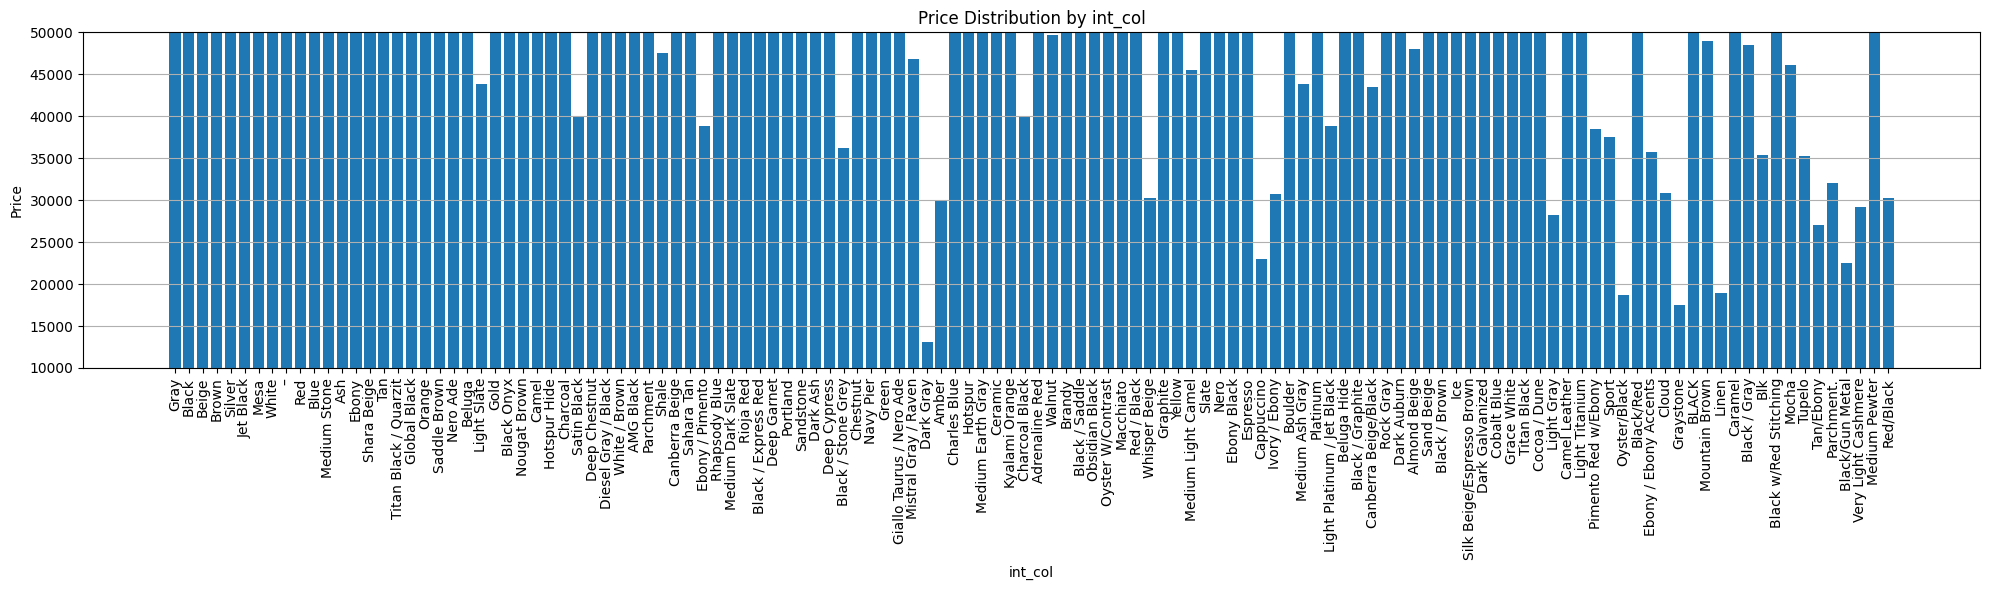

In [13]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['int_col'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('int_col')
plt.ylabel('Price')
plt.title('Price Distribution by int_col')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
plt.ylim( ymin=10000, ymax=50000 )
# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

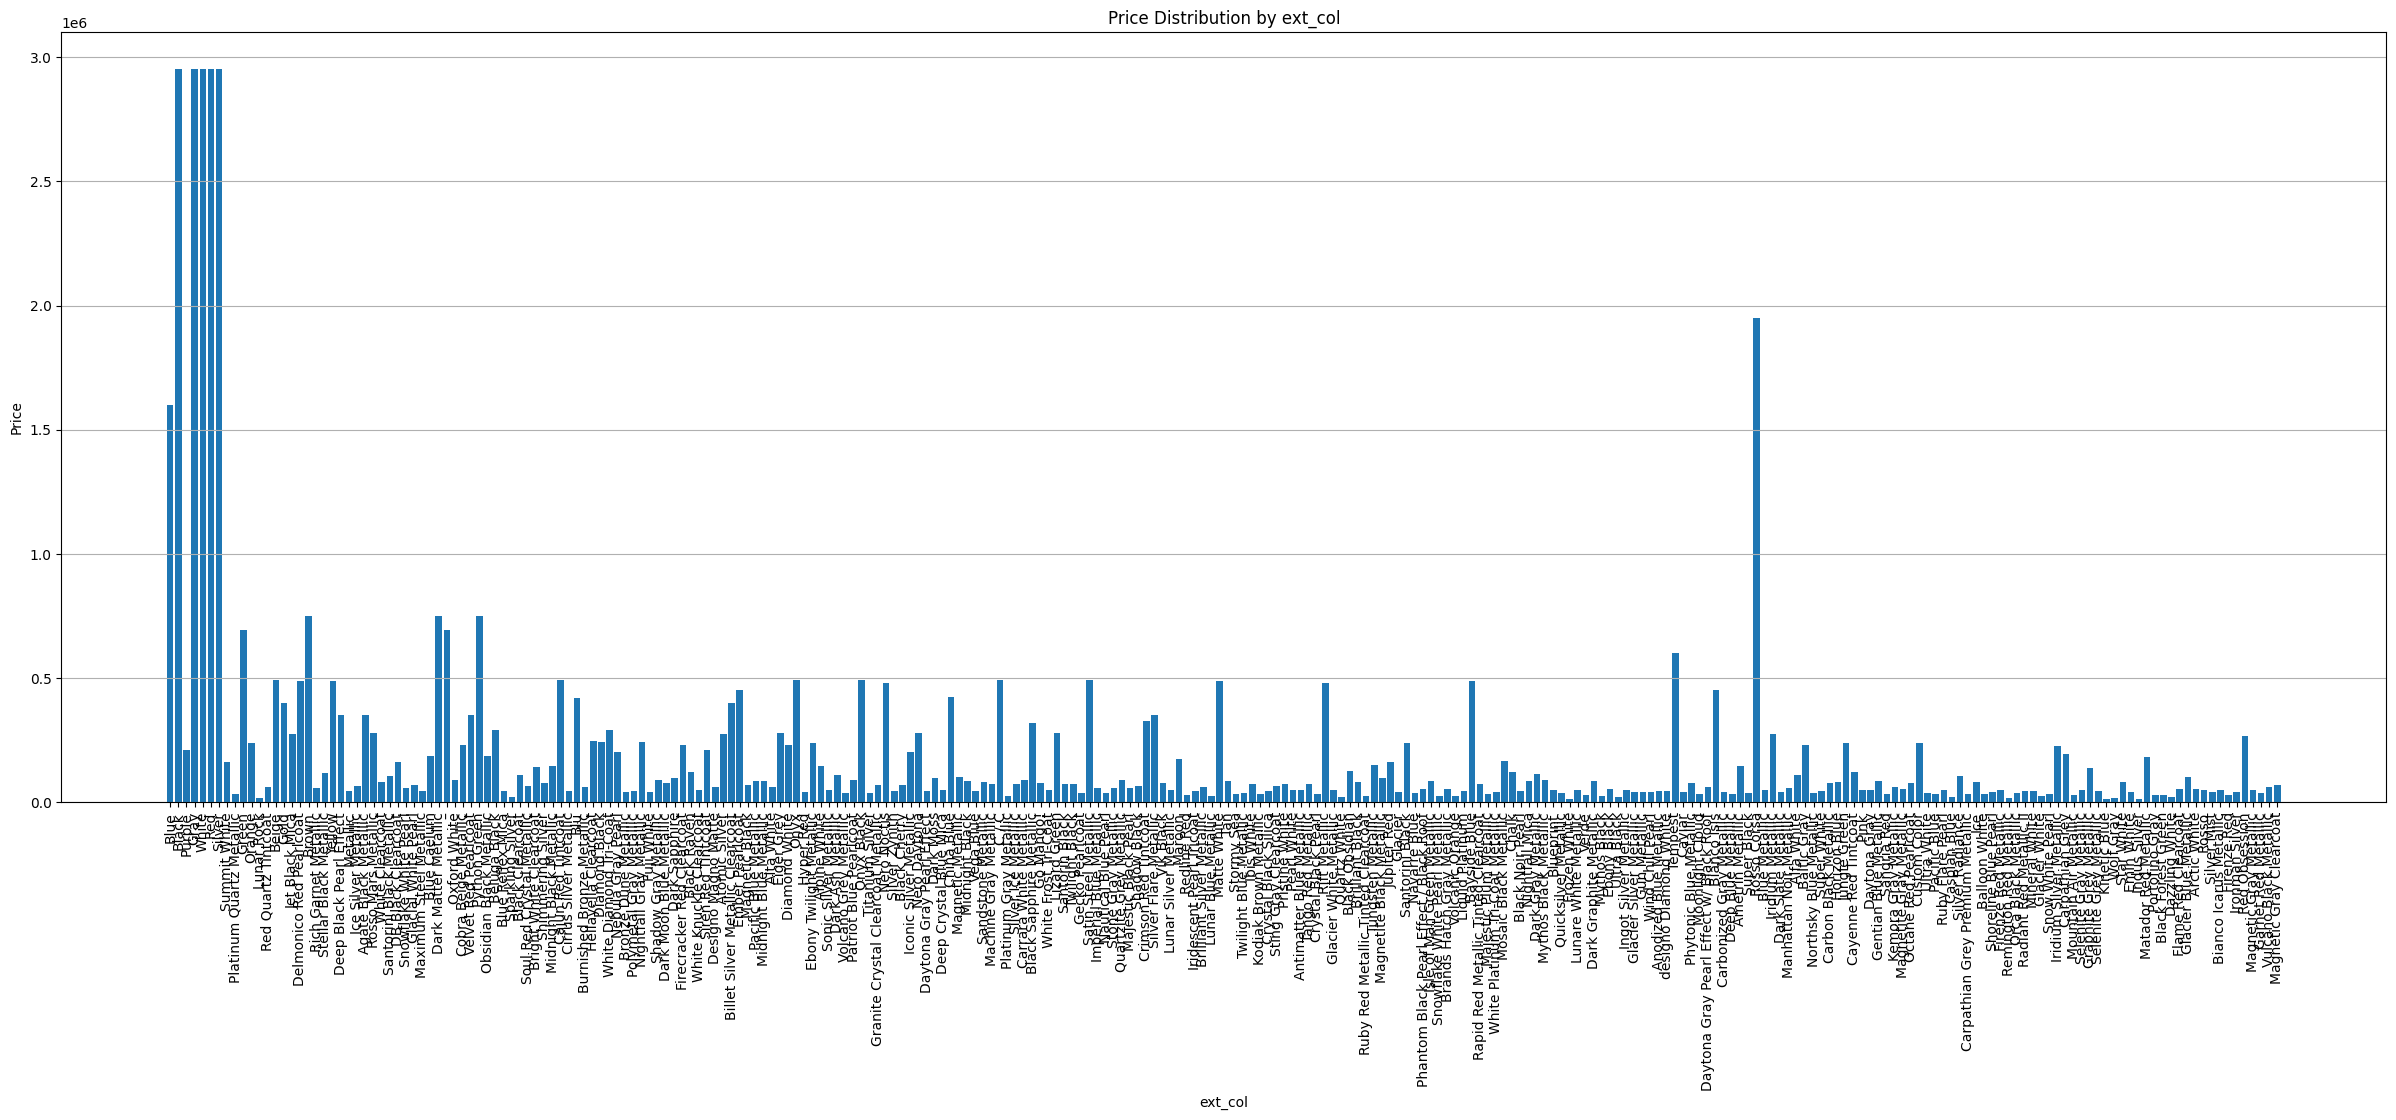

In [61]:
plt.figure(figsize=(30, 10))  # Adjust figure size as needed 
plt.bar(df['ext_col'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('ext_col')
plt.ylabel('Price')
plt.title('Price Distribution by ext_col')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
#plt.tight_layout()  # Adjust spacing between elements

# Adjust bottom margin for spacing (experiment with values)
#plt.subplots_adjust(bottom=0.01)  # Adjust the value as needed (0 to 1)

plt.show()

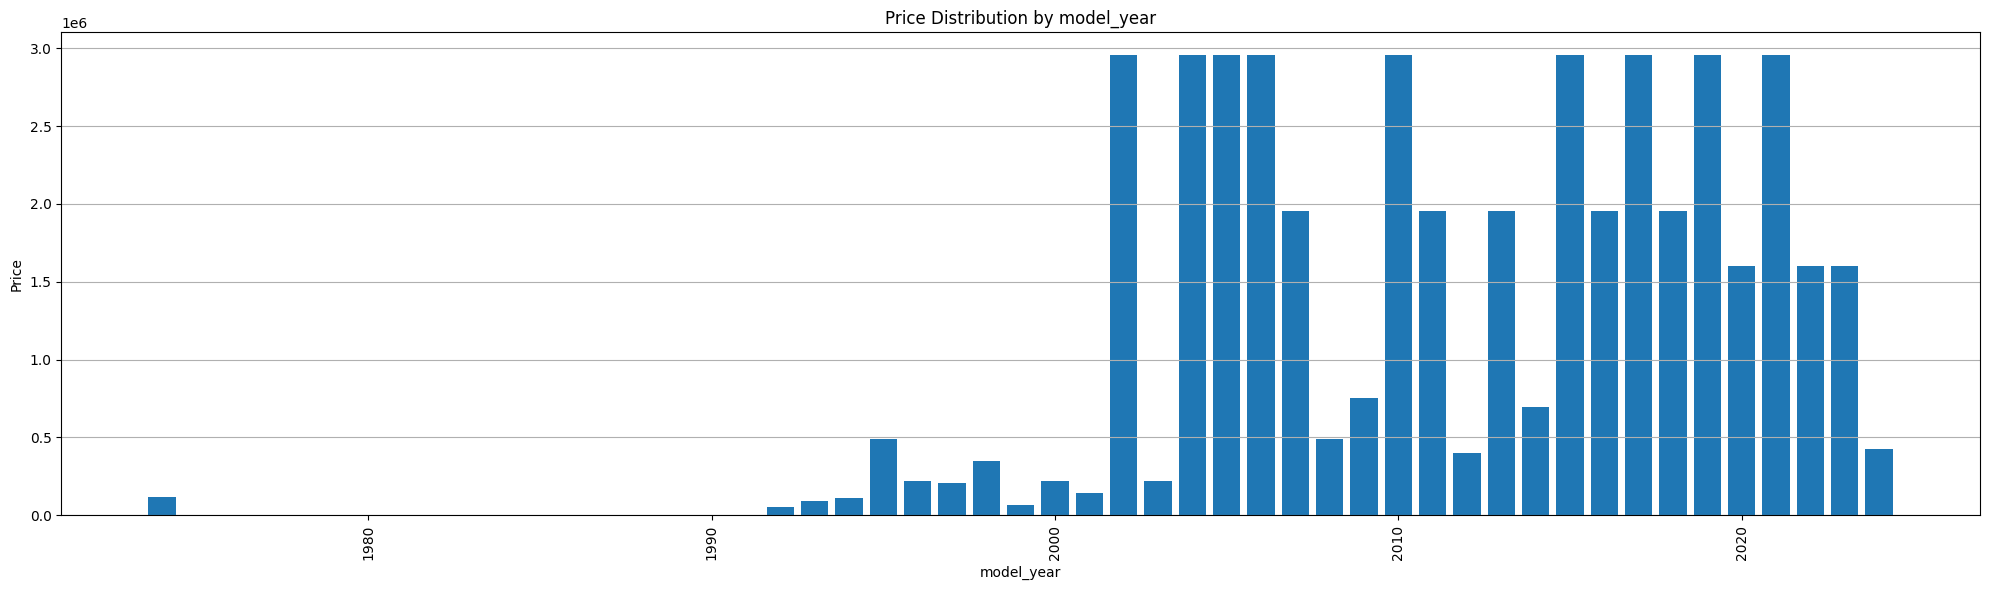

In [18]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['model_year'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('model_year')
plt.ylabel('Price')
plt.title('Price Distribution by model_year')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

# Transmission

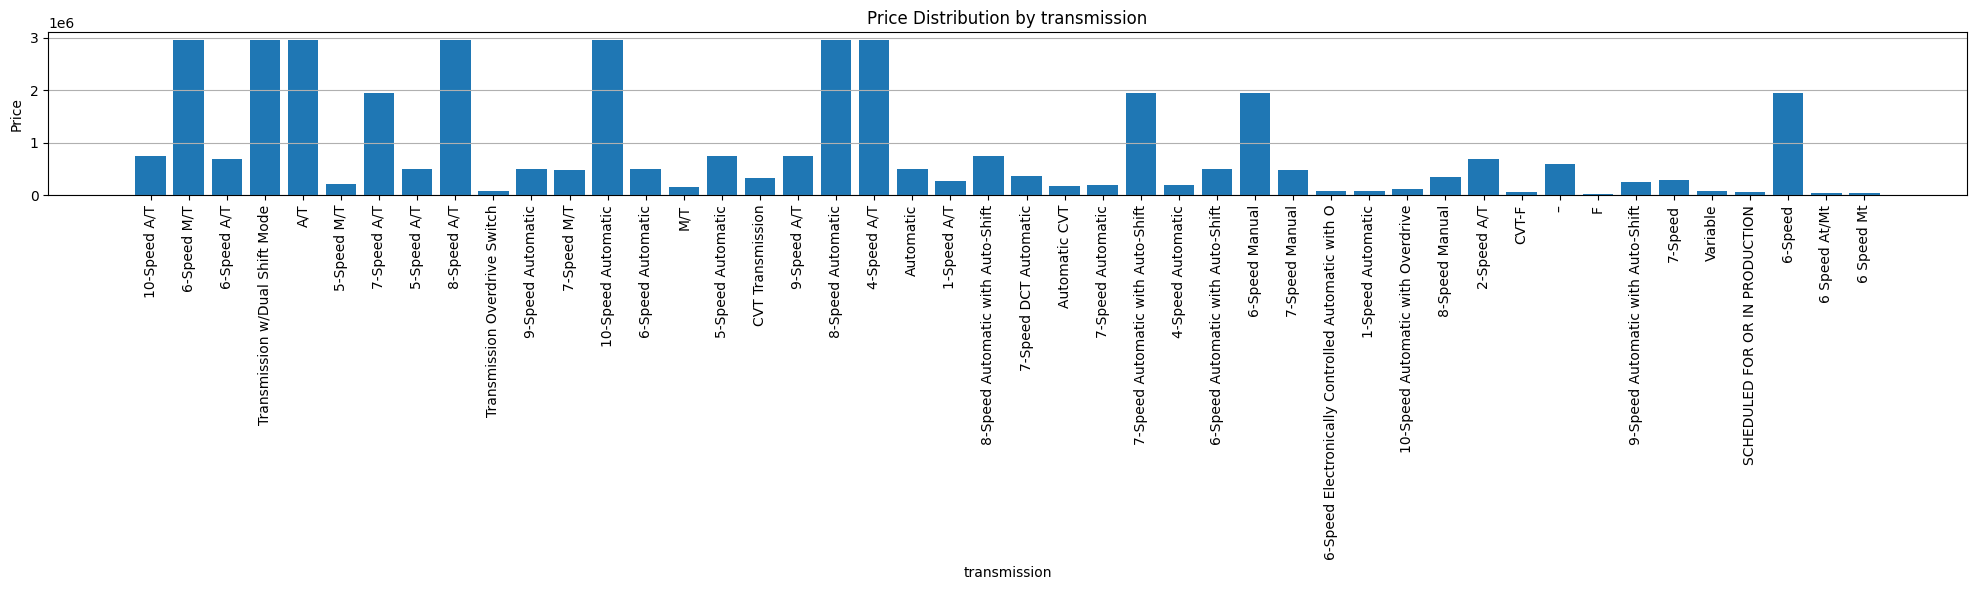

In [20]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['transmission'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('transmission')
plt.ylabel('Price')
plt.title('Price Distribution by transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

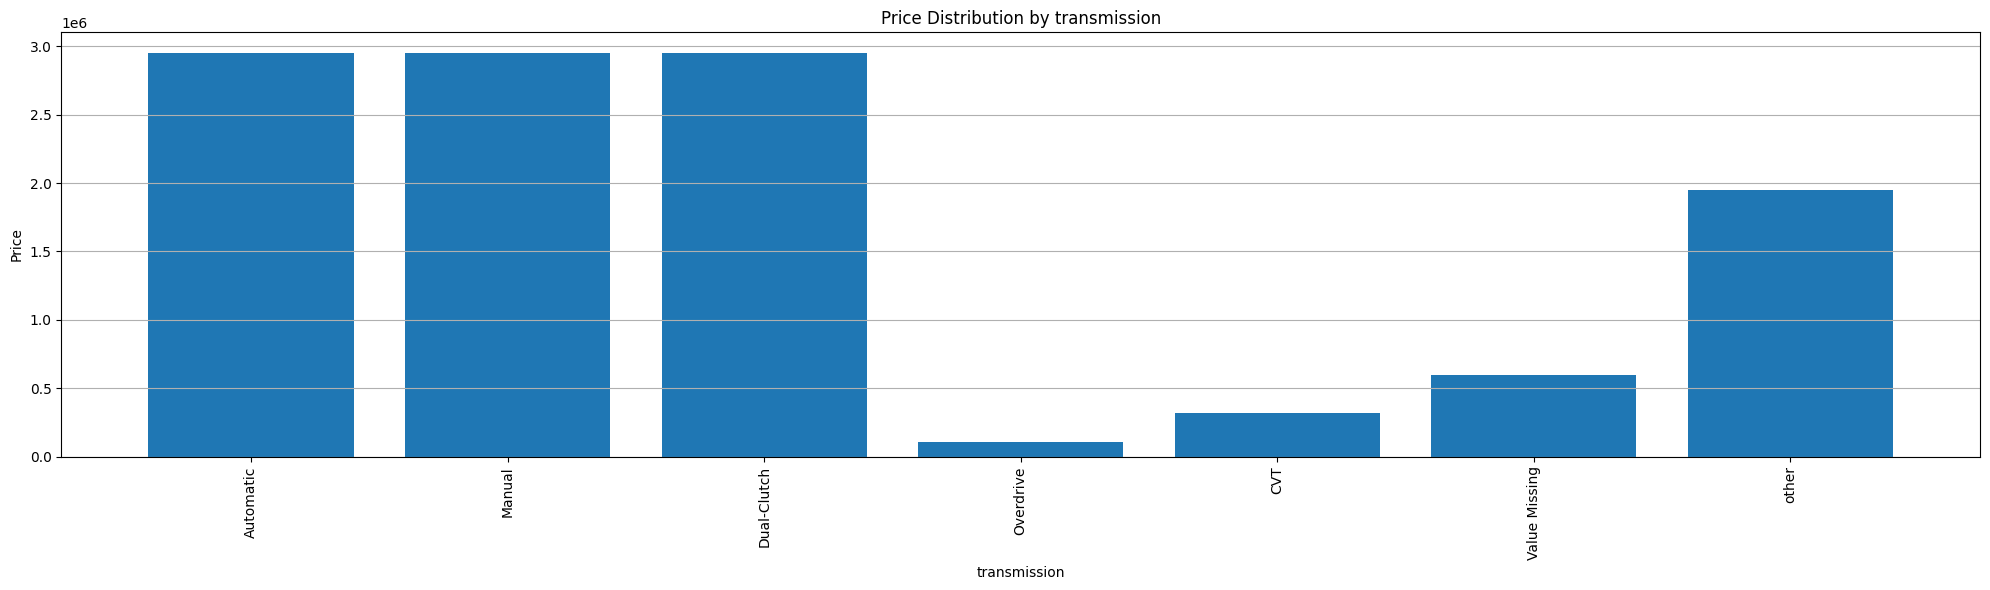

In [78]:
# Fill NaN values in transmission with a placeholder
df['transmission'].fillna('Value Missing', inplace=True)

plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['transmission'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('transmission')
plt.ylabel('Price')
plt.title('Price Distribution by transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [58]:
df['transmission'].describe()
df['transmission'].isnull().sum()

9

In [39]:
df['transmission'].str.contains('CVT').sum()

790

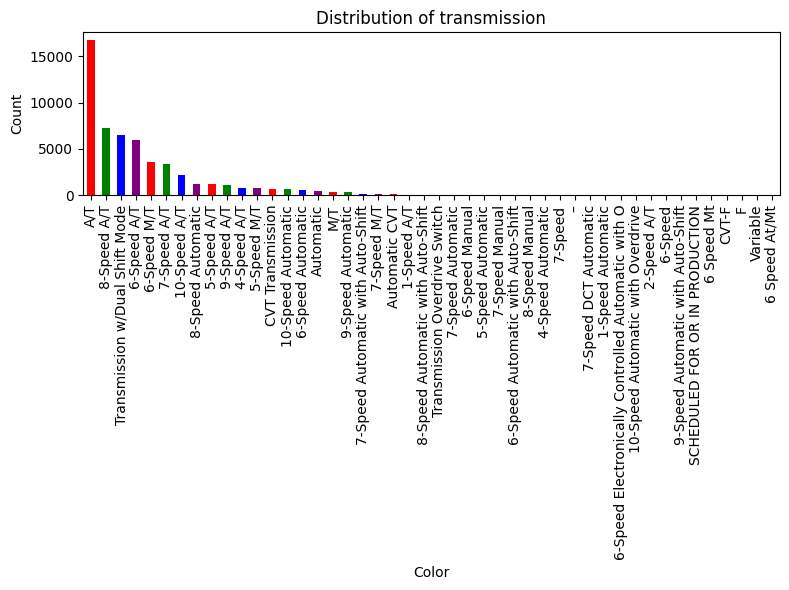

In [25]:
# Get value counts
value_counts = df['transmission'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['red', 'green', 'blue', 'purple'])  # Optional: customize colors
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Distribution of transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for readability (if many categories)
plt.tight_layout()
plt.show()

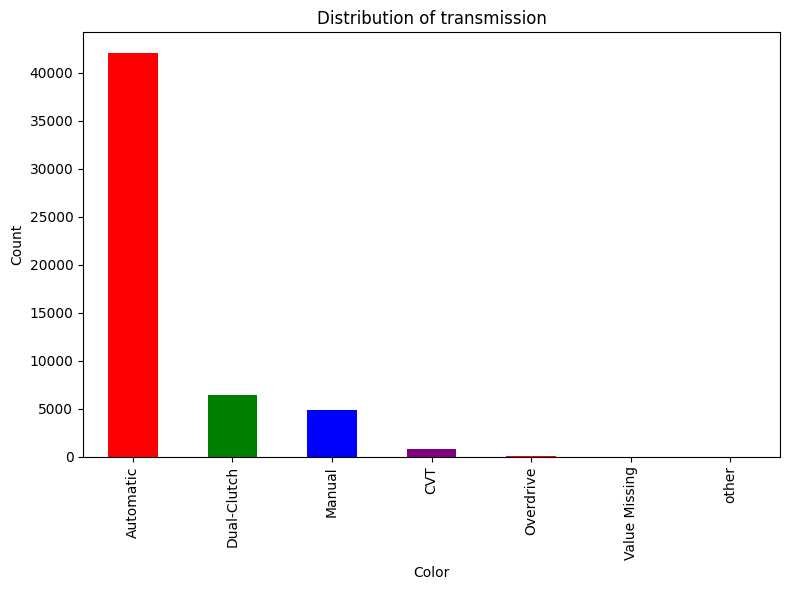

In [80]:
# Get value counts
value_counts = df['transmission'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['red', 'green', 'blue', 'purple'])  # Optional: customize colors
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Distribution of transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for readability (if many categories)
plt.tight_layout()
plt.show()

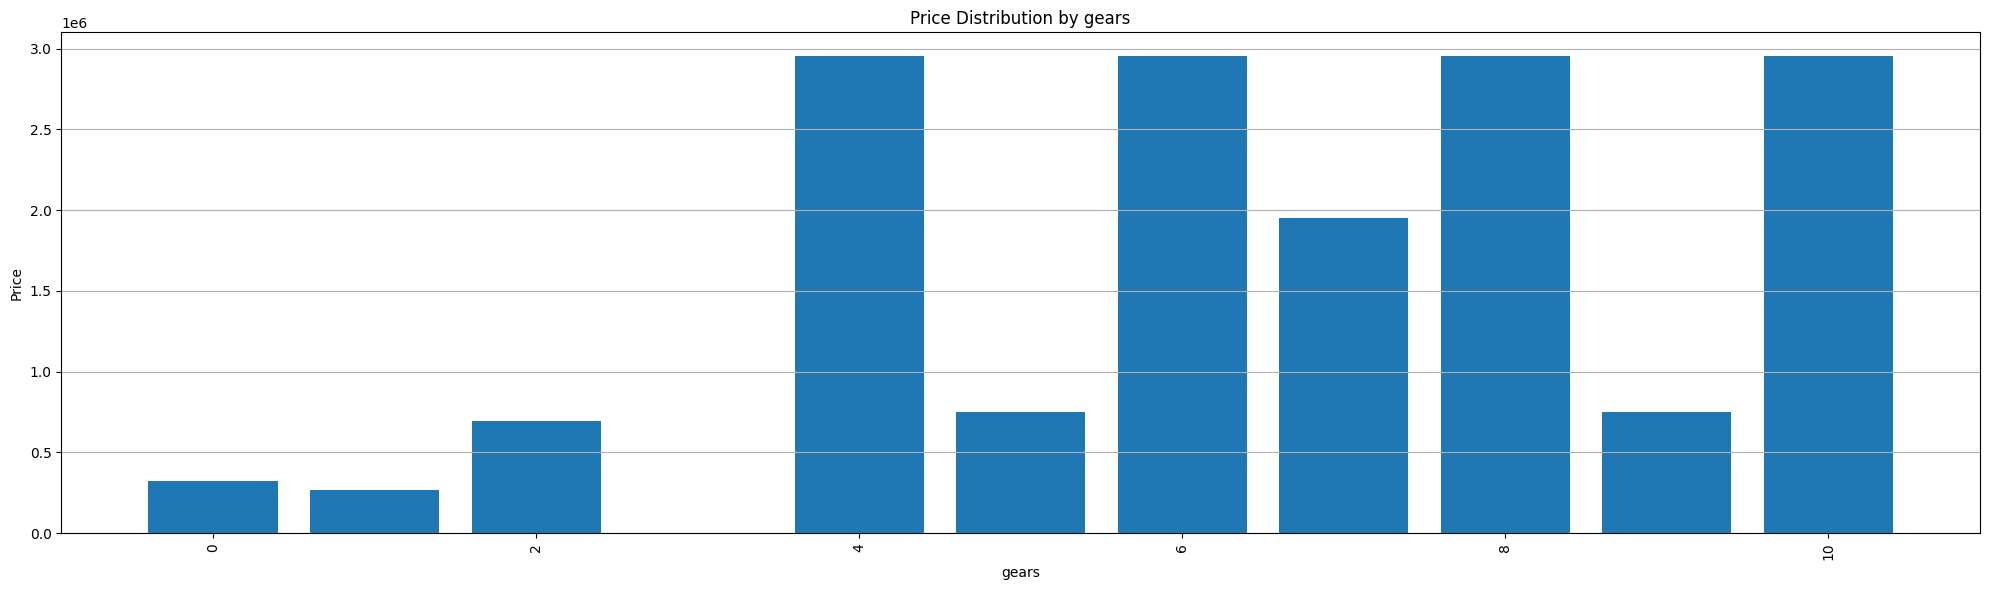

In [42]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['gears'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('gears')
plt.ylabel('Price')
plt.title('Price Distribution by gears')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [83]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  corr_matrix = numeric_features.corr(method='pearson')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,gears,price
id,1.000000,0.000741,-0.003194,0.001826,0.000587
model_year,0.000741,1.000000,-0.625226,0.472823,0.216150
milage,-0.003194,-0.625226,1.000000,-0.387428,-0.248927
gears,0.001826,0.472823,-0.387428,1.000000,0.146716
price,0.000587,0.216150,-0.248927,0.146716,1.000000


In [84]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  corr_matrix = numeric_features.corr(method='spearman')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,gears,price
id,1.000000,0.001869,-0.004924,0.004280,0.001475
model_year,0.001869,1.000000,-0.700171,0.616851,0.721409
milage,-0.004924,-0.700171,1.000000,-0.482379,-0.718992
gears,0.004280,0.616851,-0.482379,1.000000,0.533031
price,0.001475,0.721409,-0.718992,0.533031,1.000000


# Milage

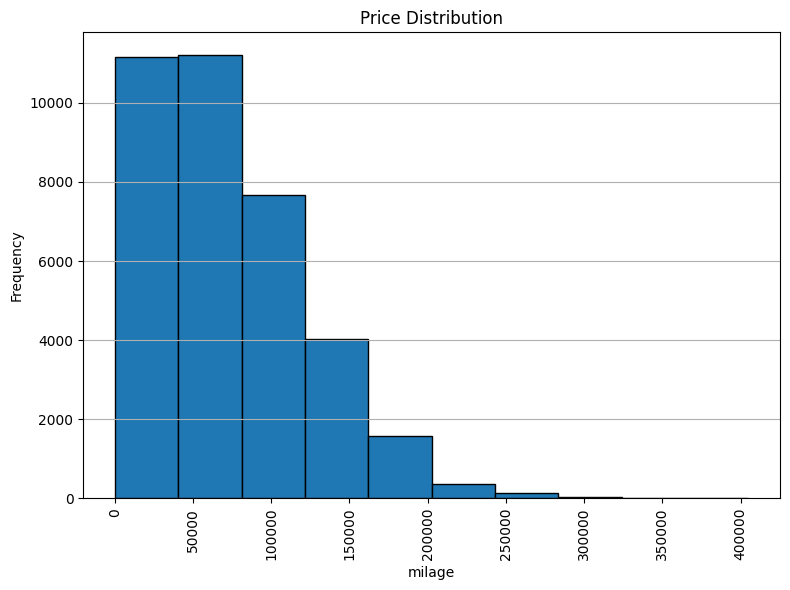

In [8]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed 
plt.hist(df['milage'], bins=10, edgecolor='black')
plt.xlabel('milage')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [ ]:
df['milage'].value_counts()

# Brand

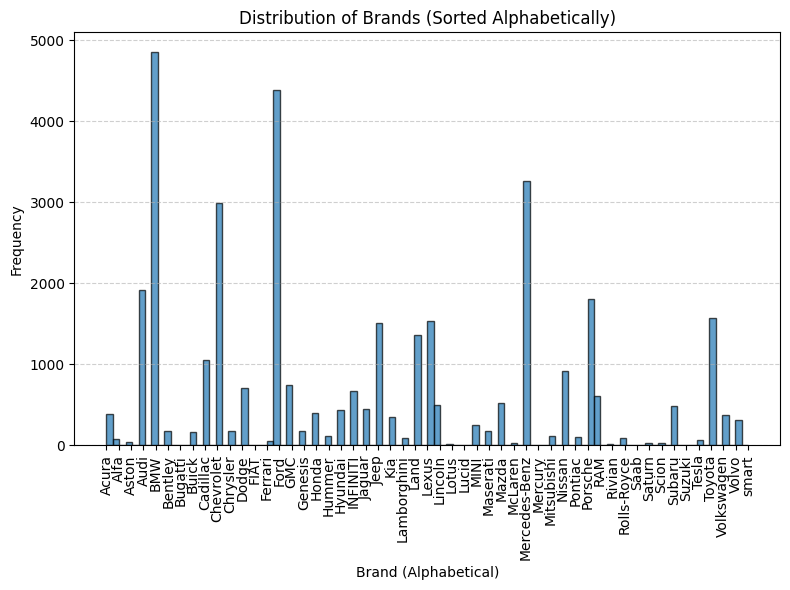

In [15]:
# Assuming 'brand' is the column containing brand names in your DataFrame (replace if necessary)
brands = df['brand'].sort_values().to_list()  # Sort brands alphabetically

# Create the histogram with informative labels and title
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.hist(brands, bins=100, edgecolor='black', alpha=0.7)  # Adjust bin count and transparency
plt.xlabel('Brand (Alphabetical)')
plt.ylabel('Frequency')
plt.title('Distribution of Brands (Sorted Alphabetically)')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Customize the plot (optional)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add grid lines with dashed style and adjusted transparency
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()


# Model year

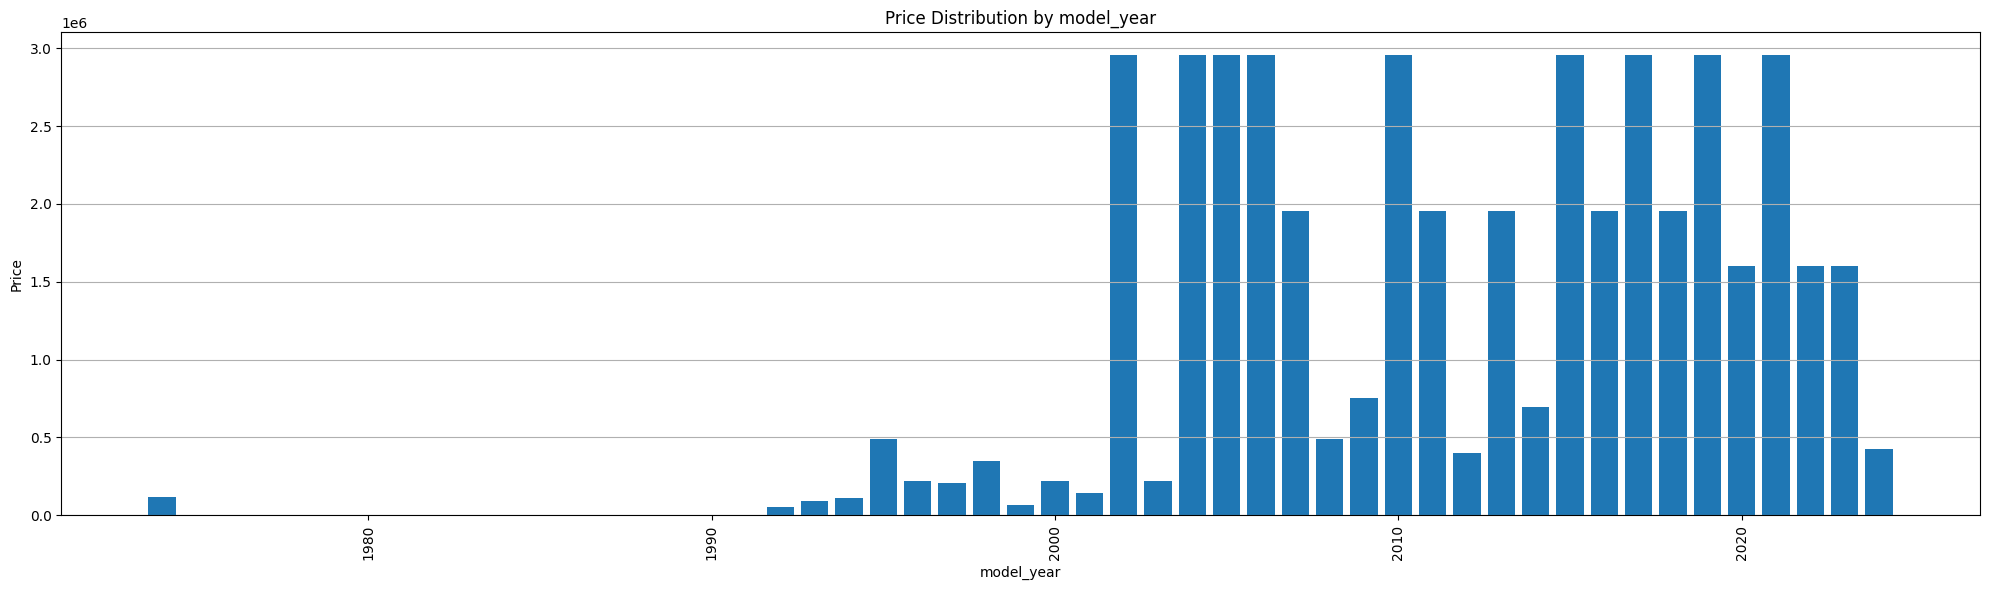

In [9]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['model_year'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('model_year')
plt.ylabel('Price')
plt.title('Price Distribution by model_year')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [9]:
# Select non-numerical columns (categorical in this case)
categorical_cols = df.select_dtypes(include=['object', 'category'])
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  corr_matrix = numeric_features.corr(method='spearman')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage
id,1.000000,0.002901,-0.005096
model_year,0.002901,1.000000,-0.697553
milage,-0.005096,-0.697553,1.000000


In [ ]:
df.drop(columns = ['clean_title'], inplace=True)
df.columns

In [70]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


# Define the function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.append('price')
# Initialize an empty DataFrame for the correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), 
                           index=categorical_columns, 
                           columns=categorical_columns)

# Compute Cramér's V for each pair of categorical columns
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

corr_matrix

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,price
brand,1.000000,0.961178,0.177546,0.802418,0.233543,0.183672,0.165746,0.165559,0.138356
model,0.961178,1.000000,0.778347,0.696765,0.558648,0.356037,0.377120,0.369239,0.112550
fuel_type,0.177546,0.778347,1.000000,0.931695,0.075607,0.030944,0.059566,0.061513,0.080503
engine,0.802418,0.696765,0.931695,1.000000,0.438220,0.298174,0.347549,0.346173,0.116204
transmission,0.233543,0.558648,0.075607,0.438220,1.000000,0.182975,0.101625,0.045325,0.178748
ext_col,0.183672,0.356037,0.030944,0.298174,0.182975,1.000000,0.474042,0.100327,0.281773
int_col,0.165746,0.377120,0.059566,0.347549,0.101625,0.474042,1.000000,0.132549,0.264371
accident,0.165559,0.369239,0.061513,0.346173,0.045325,0.100327,0.132549,1.000000,0.352725
price,0.138356,0.112550,0.080503,0.116204,0.178748,0.281773,0.264371,0.352725,1.000000
